### This notebook replicates the Naval Experiment from PMCnet paper

In [3]:
import pickle

# Define the path to the output file
output_file_path = "/Users/florianwittstock/Documents/VS Studio Code/PMCnet/results/Ionosphere/output_Ionosphere_l2_final.txt"

# Open the file for reading in binary mode
with open(output_file_path, 'rb') as fp:
    # Load the data from the pickle file
    output_data = pickle.load(fp)

# Now, output_data contains the data saved in the output file
# You can access the specific elements of the data as needed


In [4]:
# explore what is in the output_data

#print(output_data)

# check if data is a list
print(type(output_data))

print(len(output_data))

<class 'list'>
1


In [5]:
from Model_files.functions import *
from Model_files.PMCnet_algo import *

ModuleNotFoundError: No module named 'Model_files'

In [ ]:
import torch
import torch.nn.functional as F
from torch import nn
from torch import optim
import numpy as np
import math
import sys
import torch.utils.data as data
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Optimizer
from scipy.linalg import sqrtm
from scipy.stats import multivariate_normal
from sklearn import metrics
import matplotlib.pyplot as plt
from multiprocessing import Pool
import scipy.io as sio
# import time
import pandas as pd
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
import pickle
from Model_files.functions import *
from Model_files.PMCnet_algo import *
from Model_files.golden_search import *
from Model_files.run_PMCnet_fixedReg import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
import traceback

#cuda2 = torch.device('cuda:0')

folder_name_train = 'data/Ionosphere/train_data.mat'
folder_name_val = 'data/Ionosphere/val_data.mat'
folder_name_test = 'data/Ionosphere/test_data.mat'

y_train = OpenMat(sio.loadmat(folder_name_train)['y_train'])
x_train = OpenMat(sio.loadmat(folder_name_train)['x_train'])
y_val = OpenMat(sio.loadmat(folder_name_val)['y_val'])
x_val = OpenMat(sio.loadmat(folder_name_val)['x_val'])
y_test = OpenMat(sio.loadmat(folder_name_test)['y_test'])
x_test = OpenMat(sio.loadmat(folder_name_test)['x_test'])

#scale = MinMaxScaler(feature_range = (0,1))
scale = StandardScaler()
x_train = scale.fit_transform(x_train)
x_val = scale.fit_transform(x_val)
x_test = scale.fit_transform(x_test)

x_train = torch.Tensor(x_train) # transform to torch tensor
y_train = torch.Tensor(y_train)
x_val = torch.Tensor(x_val) # transform to torch tensor
y_val = torch.Tensor(y_val)
x_test = torch.Tensor(x_test) # transform to torch tensor
y_test = torch.Tensor(y_test)

print('The size of x_train is ', x_train.shape)
print('The size of y_train is ', y_train.shape)
print('The size of x_val is ', x_val.shape)
print('The size of y_val is ', y_val.shape)
print('The size of x_test is ', x_test.shape)
print('The size of y_test is ', y_test.shape)

batch_size = 10

train_dataset = TensorDataset(x_train,y_train) # create your datset
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True) 


val_dataset = TensorDataset(x_val,y_val) # create your datset
val_loader = DataLoader(val_dataset, batch_size = x_val.shape[0], shuffle = True) # not use minibatch


test_dataset = TensorDataset(x_test,y_test) # create your datset
test_loader = DataLoader(test_dataset, batch_size =  x_test.shape[0], shuffle = False) # not use minibatch

In [6]:
# create a dictionary to save options
hidden_layer = 5 # the number of neurons in the hidden layer # L=2

tp = {}
tp['L'] = 2
tp['S'] = 1
if tp['L'] != 1:
    tp['M'] = [x_train.shape[1],hidden_layer,1] # the map
else:
    tp['M'] = [x_train.shape[1],1] # the map
tp['prior'] = 'L2' #'no_prior', 'Gaussian_prior', 'Laplace_prior','L2'
tp['x_0'] = x_train
tp['y'] = y_train
tp['regularization_weight'] = 0.07739783490124956
if tp['prior'] == 'no_prior':# MLE
    prior_W = 'no_prior'
    prior_b = 'no_prior'
    tp['prior_W'] = prior_W
    tp['prior_b'] = prior_b
elif tp['prior'] == 'Gaussian_prior':
    prior_W = isotropic_gauss_prior(mu=0, sigma=2)
    prior_b = isotropic_gauss_prior(mu=0, sigma=2)
    tp['prior_W'] = prior_W
    tp['prior_b'] = prior_b
elif tp['prior'] == 'Laplace_prior':# MAP+L1 regularization
    prior_sig = 0.1
    prior = laplace_prior(mu=0, b=prior_sig)
elif tp['prior'] == 'L2': # L2 regularization
    prior_W = 'L2'
    prior_b = 'L2'
    tp['prior_W'] = prior_W
    tp['prior_b'] = prior_b
elif tp['prior'] == 'L1': # L1 regularization
    prior_W = 'L1'
    prior_b = 'L1'
    tp['prior_W'] = prior_W
    tp['prior_b'] = prior_b       
print('The prior is ',tp['prior'])        
L = tp['L']
M = tp['M']
total_number = 0
for ll in range(L):
    total_number += M[ll]*M[ll+1]+M[ll+1]
tp['dimension'] = total_number  
tp['activation'] = ['tanh','None']
tp['classification'] = 'binary'

The prior is  L2


In [ ]:
folder_name_params = 'params/Ionosphere'

W1 = OpenMat(sio.loadmat(os.path.join(folder_name_params,'W1.mat'))['W1'])
b1 = OpenMat(sio.loadmat(os.path.join(folder_name_params,'b1.mat'))['b1'])
W2 = OpenMat(sio.loadmat(os.path.join(folder_name_params,'W2.mat'))['W2'])
b2 = OpenMat(sio.loadmat(os.path.join(folder_name_params,'b2.mat'))['b2'])
  
    
print('the shape of W1 is ',W1.shape)
print('the shape of b1 is ',b1.shape)
if hidden_layer != 0:
    print('the shape of W2 is ',W2.shape)
    print('the shape of b2 is ',b2.shape)

W_mu1 = W1
b_mu1 = b1

if hidden_layer != 0:
    W_mu2 = W2
    b_mu2 = b2


# est_ml is the set of all parameters (W,b), stacked in a column 
if hidden_layer == 0:
    est_ml = torch.cat((torch.transpose(W_mu1,0,1).reshape(M[0]*M[1],1),b_mu1.reshape(M[1],1)),0)
else:
    est_ml1 = torch.cat((torch.transpose(W_mu1,0,1).reshape(M[0]*M[1],1),b_mu1.reshape(M[1],1)),0)
    est_ml2 = torch.cat((torch.transpose(W_mu2,0,1).reshape(M[1]*M[2],1),b_mu2.reshape(M[2],1)),0)
    est_ml = torch.cat((est_ml1,est_ml2),0)

In [8]:
T = 5

In [9]:
#parameters for our algorithm
N = 10  # number of proposals #50
K = 10  # samples per proposal per iteration #100
sig_prop = 0.1
lr = 2  #glocal resampling
gr_period=2
tp['regularization_weight'] = 0.07739783490124956
epsilon1 = 1e-50
epsilon2 = 1e-50
T = 5

output = SL_PMC_Adapt_Cov_new(N,K,T,sig_prop,lr,gr_period,tp,est_ml,epsilon1,epsilon2)

/Users/florianwittstock/Documents/VS Studio Code/PMCnet/Model_files/functions.py:221: UserWarning: torch.cholesky is deprecated in favor of torch.linalg.cholesky and will be removed in a future PyTorch release.
L = torch.cholesky(A)
should be replaced with
L = torch.linalg.cholesky(A)
and
U = torch.cholesky(A, upper=True)
should be replaced with
U = torch.linalg.cholesky(A).mH().
This transform will produce equivalent results for all valid (symmetric positive definite) inputs. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:1702.)
  R = torch.cholesky(Sigma[:,:,i], upper = True)
/Users/florianwittstock/Documents/VS Studio Code/PMCnet/Model_files/functions.py:251: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(fp_mixt)
/Users/florianwittstock/Documents/VS 

['Iteration ', 0, ': we discard ', 10, '/', 10, ' Sigma matrices']
do gr
['Iteration ', 1, ': we discard ', 10, '/', 10, ' Sigma matrices']
['Iteration ', 2, ': we discard ', 10, '/', 10, ' Sigma matrices']
do gr
['Iteration ', 3, ': we discard ', 10, '/', 10, ' Sigma matrices']
['Iteration ', 4, ': we discard ', 10, '/', 10, ' Sigma matrices']


In [10]:
# transform tuple output into dictionary with keys Mean_est_evolution,Z_est_evolution,all_samples, all_weights,all_proposals,all_Sigma,mean_est_part,Z_part,m2_est_evolution,m2_part,map_estimator,logf_save,ct_vec,samples_resampled_adapted,Sigma_resampled

output_dict = {}
output_dict['Mean_est_evolution'] = output[0]
output_dict['Z_est_evolution'] = output[1]
output_dict['all_samples'] = output[2]
output_dict['all_weights'] = output[3]
output_dict['all_proposals'] = output[4]
output_dict['all_Sigma'] = output[5]
output_dict['mean_est_part'] = output[6]
output_dict['Z_part'] = output[7]
output_dict['m2_est_evolution'] = output[8]
output_dict['m2_part'] = output[9]
output_dict['map_estimator'] = output[10]
output_dict['logf_save'] = output[11]
output_dict['ct_vec'] = output[12]
output_dict['samples_resampled_adapted'] = output[13]
output_dict['Sigma_resampled'] = output[14]

In [11]:
output_dict.keys()

dict_keys(['Mean_est_evolution', 'Z_est_evolution', 'all_samples', 'all_weights', 'all_proposals', 'all_Sigma', 'mean_est_part', 'Z_part', 'm2_est_evolution', 'm2_part', 'map_estimator', 'logf_save', 'ct_vec', 'samples_resampled_adapted', 'Sigma_resampled'])

(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 1., 0.,
        0., 1., 0., 2., 0., 2., 0., 1., 1., 3., 4., 2., 1., 4., 5., 2., 1.,
        2., 3., 2., 0., 3., 2., 5., 7., 4., 2., 5., 3., 4., 2., 3., 8., 5.,
        1., 3., 0., 1., 7., 5., 3., 9., 3., 3., 3., 2., 5., 6., 2., 4., 5.,
        1., 1., 2., 2., 3., 0., 1., 0., 1., 1., 2., 0., 0., 0., 0., 2., 1.,
        1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([-4.80393267, -4.70846605, -4.61299944, -4.51753235, -4.42206573,
        -4.32659912, -4.23113251, -4.13566542, -4.0401988 , -3.94473219,
        -3.84926534, -3.75379872, -3.65833187, -3.56286526, -3.46739841,
        -3.37193179, -3.27646494, -3.18099833, -3.08553147, -2.99006486,
        -2.89459801, -2.79913139, -2.70366454, -2.60819793, -2.51273108,
        -2.41726446, -2.32179785, -2.226331  , -2.13086438, -2.03539753,
        -1.9399308 , -1.84446406, -1.74899733, -1.6535306 , -1.55806386,
        -1.46259713, -1.3671304 , -1.27

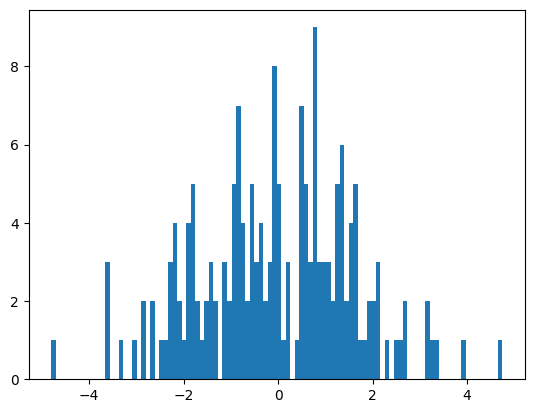

In [15]:
samples = output_dict['samples_resampled_adapted']

# transform samples into a numpy array
samples_array = samples.cpu().numpy()

# how many dimensions does the samples_array have?
samples_array.shape

# plot me all 10 dimensions of the samples_array as histograms in the same plot
fig, axs = plt.subplots(2, 5, figsize=(20, 8))



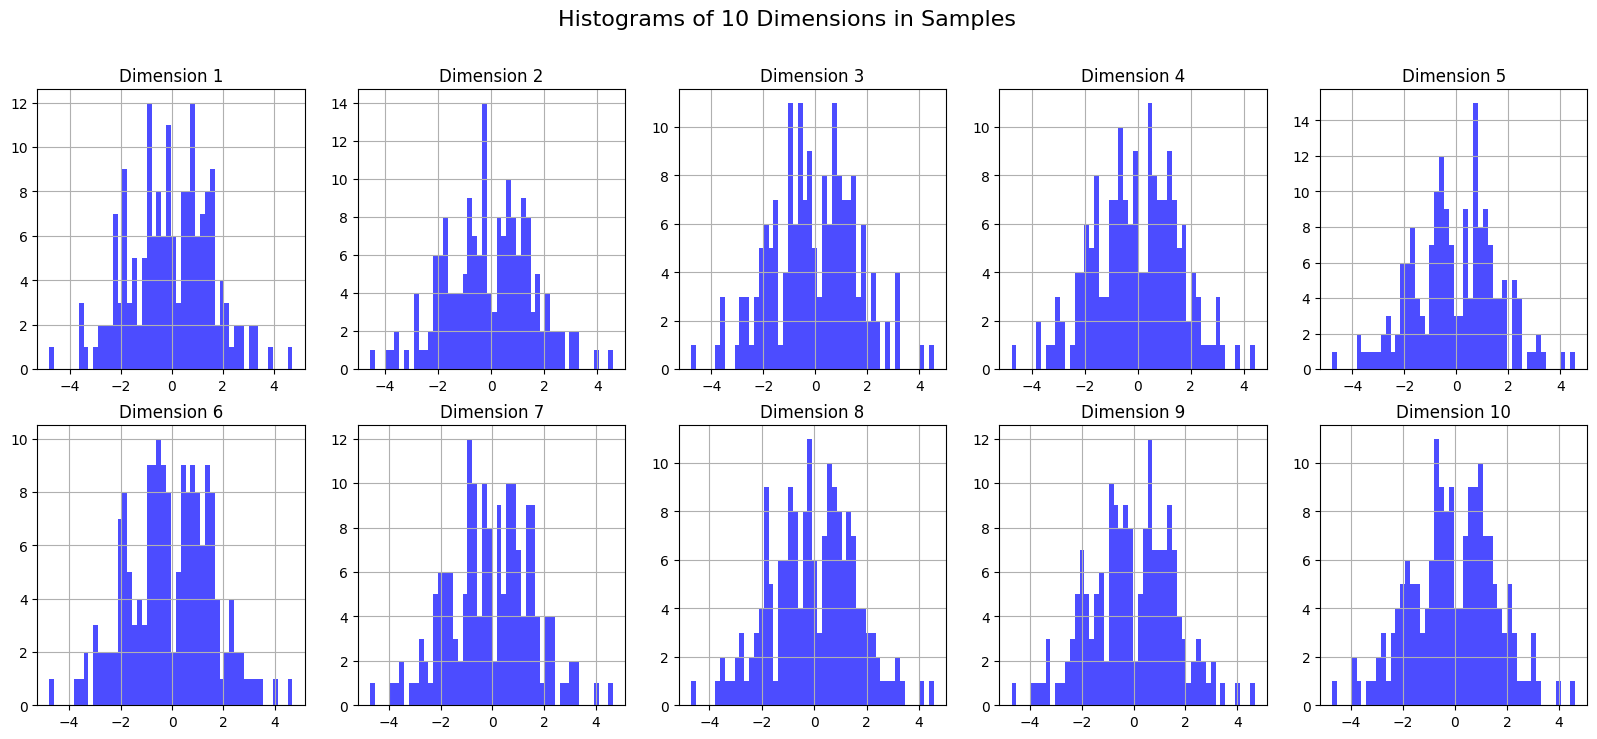

In [16]:
import matplotlib.pyplot as plt

# Assuming samples_array has a shape of (number_of_samples, dimension)
# If not, adjust the axis accordingly based on the shape

# Plot histograms for all 10 dimensions
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle('Histograms of 10 Dimensions in Samples', fontsize=16)

for i in range(2):
    for j in range(5):
        # Calculate the index for the dimension
        dim_index = i * 5 + j
        
        # Plot histogram for the current dimension
        axs[i, j].hist(samples_array[:, dim_index], bins=50, color='blue', alpha=0.7)
        axs[i, j].set_title(f'Dimension {dim_index + 1}')
        axs[i, j].grid(True)

# Add a title to the overall plot
plt.show()


### Regression Large


In [3]:
import torch
import torch.nn.functional as F
from torch import nn
from torch import optim
import numpy as np
import math
import sys
import torch.utils.data as data
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Optimizer
from scipy.linalg import sqrtm
from scipy.stats import multivariate_normal
from sklearn import metrics
import matplotlib.pyplot as plt
from multiprocessing import Pool
import scipy.io as sio
import time
import pandas as pd
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
import pickle
from Model_files.functions import *
from Model_files.PMCnet_light_algo_regression_large import *
from Model_files.golden_search import *
from Model_files.run_PMCnet_fixedReg_regression_large import *
from Model_files.model_regression import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
import traceback

In [28]:
def SL_PMC_Adapt_Cov_new(train_loader,N,K,T,sig_prop,lr,gr_period,tp,est_ml,epsilon1, epsilon2):

    #Initialisation (using ADAM ML solution, maybe not the best idea)
    M_=len(est_ml) # number of unknown parameters # 16
    initial_means=est_ml.cpu().repeat(1,N)+0.001*torch.randn(M_,N).cpu()

    #Variance of the proposals 
    Sigma0_small=(torch.ones(M_,1)*(sig_prop**2)).double().cpu()
    Sigma0=Sigma0_small.repeat(1,N) # M*N

    #parameters for the covariance adaptation
    steps = 1
    coef_step = 0.1
    cov_type = 2
    beta0 = 0.5
    increase_beta = 0
    eta0 = 1
    decrease_eta = 1
    PMC_b = True
   

    fraction=(math.sqrt(K))/K

    # variables in which the outputs are stored
    all_proposals=[[] for t in range(T)]
    all_Sigma=[[] for t in range(T)]
    all_samples=[[] for t in range(T)]
    Z_part=[]
    Z_est_evolution=[]
    all_weights=[]
    logf_save = []
    w_sum=[]
    mean_est_part=[]
    m2_part=[]
    Mean_est_evolution=[]
    m2_est_evolution=[]
    sample_Cov=[]
    parents_samples_resampled=[]
    all_samples_resampled_pre=[]
    beta=[]
    eta=[]
    rob_Cov_1=[]
    rob_Cov_2=[]
    ct_vec = []
    Stot=0
    val_max=torch.tensor(-float("Inf"))
    for t in range(T):
        #print that iteration t is starting
        print(f'Starting Iteration {t}')
        # 0. Update proposals
        if t == 0: # First iteration
            proposals_temp=initial_means # Initialized means
            Sigma_temp=Sigma0.cpu()

        else: #Next iterations
            proposals_temp=samples_resampled_adapted.float() # Proposal means are the resampled particles of previous iteration
            Sigma_temp=Sigma_resampled.cpu() #  no sigma adaptation
        # 1. Sampling (propagate proposals)
        all_samples_0 = []
        for n in range(N): # N proposal distributions
            a = proposals_temp[:,n].unsqueeze(-1).repeat(1, K)+torch.randn(M_,K).cpu()*torch.tensor(Sigma_temp[:,n]**(1/2)).unsqueeze(-1).float().cpu()
            if n == 0:
                all_samples_0 = a
            else:    
                all_samples_0 = torch.cat((all_samples_0,a),1)
        all_samples[t] = all_samples_0
        temp = diagevaluate_proposal_multiple_fullCov(all_samples[t], proposals_temp, Sigma_temp, N) 
        fp_mixt=np.array(temp.cpu(), dtype=np.float64)
        logP = np.log(fp_mixt+epsilon1)
        # evaluate the Bayes NN target
        sample_number = all_samples[t].shape[1]
        nlogf = []
        for s in range(sample_number):
            _, _, nlogf_temp = evaluate_target_general_regression_large(all_samples[t][:,s].double(),tp)
            nlogf.append(nlogf_temp)
        logf = -torch.tensor(nlogf)
        print(f'Sampled proposals for iteration {t}')
        
        # 2. Weighting
        logf = logf-logf.max()
        logf_np = np.array(logf.detach().numpy())
        w_temp1 = np.exp(logf_np)#+epsilon1
        w_temp2 = np.exp(-logP)
        w = w_temp1*w_temp2
        w = np.nan_to_num(w) 
        if np.sum(w) == 0:
            wn = 1/len(w)*np.ones(len(w))
        else:    
            wn=w/np.sum(w)
        w_sum.append(np.sum(w))# Sum of raw weightsC    


        val_now = torch.max(logf)
        ind_now = torch.argmax(logf)
        if val_now > val_max :
            val_max = val_now

        wn_D = np.repeat(wn.reshape(1,len(wn)),M_,axis=0)

        Stot += w_sum[t]
        all_weights.append(w)
        print(f'Completed weighting for iteration {t}')

        # 3. Multinomial resampling 
        if lr == 1:
            pos=[]
            for j in range(N):
                proposal_indices = [i for i in range(j*K, (j+1)*K)] # every K elements
                wn_temp = wn[proposal_indices] 
                wn_temp = np.nan_to_num(wn_temp)
                wn_n = (wn_temp+epsilon2)/np.sum(wn_temp+epsilon2)
                wn_n = np.nan_to_num(wn_n)
                pos.append(int(np.random.choice(proposal_indices,1, replace = True, p =wn_n)))


        elif  lr ==2 : # local resampling but every tp.gr_period, we do gr
            if (t+1)%gr_period== 0: # do gr  
                print('do gr')
                pos = np.random.choice([i for i in range(N*K)], N, replace = True, p = wn )
            else : # do lr
                pos=[]
                for j in range(N):
                    proposal_indices = [i for i in range(j*K, (j+1)*K)] # every K elements
                    wn_temp = wn[proposal_indices] 
                    wn_temp = np.nan_to_num(wn_temp)
                    wn_n = (wn_temp+epsilon2)/np.sum(wn_temp+epsilon2)
                    wn_n = np.nan_to_num(wn_n)
                    pos.append(int(np.random.choice(proposal_indices,1, replace = True, p =wn_n)))

        pos=np.array(pos)
        samples_resampled=all_samples[t][:,pos]
        parents_samples_resampled.append((pos//K))
        all_samples_resampled_pre.append(samples_resampled)
        print(f'Completed multinomial resampling for iteration {t}')
        
        # 4 COVARIANCE + SCALE LANGEVIN ADAPTATION
#         4.1 Sample covariance
        sample_Cov_0=[] 
        rob_Cov_1_0=[]   
        rob_Cov_2_0=[]
        all_weights_new = all_weights[t].copy()  
        for n in range(N):
            ind_nn = [i for i in range((n)*K, (n+1)*K)]
            samples_nn = all_samples[t][:,ind_nn]
            weights_nn = all_weights_new[ind_nn]
            weights_nn = np.nan_to_num(weights_nn)
            norm_weights = (weights_nn+epsilon2)/np.sum(weights_nn+epsilon2)
            W_bessel_n = 1 - np.sum(norm_weights**2)
            sample_mean_nn = torch.sum(torch.tensor(norm_weights).cpu().reshape(1,len(norm_weights)).repeat(M_, 1)*samples_nn,1)

            sample_Cov_nn = diagweightedcov(torch.transpose(samples_nn,0,1).double(),norm_weights) # is the sample covariance approximated # it's a symmetric matrix
            norm_weights_cropped = crop_weights(norm_weights,fraction)
            sample_Cov_nn_cropped = diagweightedcov(torch.transpose(samples_nn,0,1).double(),norm_weights_cropped)#  sample_Cov_nn_cropped is (a possibly biased) stable estimator of the covariance matrix
            # set beta
            if increase_beta == 1:
                beta.append(beta0**(-0.5*(t+1)))
            else:
                beta.append(beta0)
            # set eta
            if decrease_eta == 1:
                eta.append(eta0/(t+1))
            else:
                eta.append(eta0)
            if t==0 :
                rob_Cov_1_0.append(sample_Cov_nn)

                rob_Cov_2_0.append((1-eta[t])*sample_Cov_nn + eta[t]*sample_Cov_nn_cropped)
            else :
                parent_index_new = parents_samples_resampled[t][n]

                rob_Cov_1_0.append((1-beta[t])*rob_Cov_1[t-1][parent_index_new] + beta[t]*sample_Cov_nn)
                rob_Cov_2_0.append((1-beta[t])*rob_Cov_2[t-1][parent_index_new] + beta[t]*(1-eta[t])*sample_Cov_nn + beta[t]*eta[t]*sample_Cov_nn_cropped)  

        sample_Cov.append(sample_Cov_0)
        rob_Cov_1.append(rob_Cov_1_0)
        rob_Cov_2.append(rob_Cov_2_0) # ias covariance matrix of the proposal density for next iteration
        print(f'Completed Covariance estimation for iteration {t}')

        # mean adaptation using Langevin
        ct = 0
        Save_A=[]
        samples_resampled_adapted = torch.zeros(M_,N).cpu()
        Sigma_resampled = torch.zeros(M_,N).cpu()
        gradient_save = []
        samples_save = []
        for n in range(N):
            samples_resampled_n = samples_resampled[:,n].reshape(M_,1)
            # use mini-batch
            batch = 0
            for x_train, y_train in train_loader:
                if batch == 0:
                    samples_resampled_n = samples_resampled_n
                elif batch > 0:
                    samples_resampled_n = samples_resampled_adapted_0

                # print every 10th batch
                if batch % 10 == 0:
                    print(f'This is batch {batch} for proposal {n}')
                
                tp_temp = copy.deepcopy(tp)
                tp_temp['x_0'] = x_train
                tp_temp['y'] = y_train
                print(f'This is before we calculate the gradients for sample {n} in iteration {t}')
                W_g,B_g,l = evaluate_target_general_regression_large(samples_resampled_n.double(),tp_temp)
                if cov_type==0 :
                    A_n = sample_Cov[t][n]
                elif cov_type==1:
                    A_n=rob_Cov_1[t][n]
                elif cov_type==2 :    
                    A_n=rob_Cov_2[t][n]    
                flag_A = 1
                if flag_A == 1:
                    if (np.isreal(np.sqrt(A_n.cpu().numpy()))).all() == False:
                        flag_A = 0
                if flag_A == 0:
                    ct = ct+1
                    if t == 0:
                        Save_A.append(Sigma0_small.double().cpu())
                    else:
                        parent_index_new = parents_samples_resampled[t][n]
                        Save_A.append(Past_A[parent_index_new])
                else:
                    Save_A_temp = A_n
                dirn = Param2vec(W_g,B_g,tp_temp)
                dn =  (Save_A_temp.float()*dirn.squeeze(-1)).unsqueeze(-1)
                mysteps = steps
                cts = 0
                f_0=l
                print(f'This is before we calculate loss after adaptation for batch {batch} for proposal {n} in iteration {t}')
                _,_,f_s = evaluate_target_general_regression_large((samples_resampled_n - mysteps*dn).double(),tp_temp)
                
                
                # Set a maximum number of trials
                max_trials = 20

                while f_s > f_0 and cts < max_trials:
                    mysteps = mysteps*coef_step
                    cts = cts + 1
                    _,_,f_s = evaluate_target_general_regression_large((samples_resampled_n - mysteps*dn).double(),tp_temp)
                    print(f'This value of f_s is {f_s} and the value of f_0 is {f_0}')
                    print(f'This is adaptation trial {cts}')
                
                if cts >= max_trials:
                    samples_resampled_adapted_0 = samples_resampled_n.double()
                    samples_resampled_adapted[:,n] = samples_resampled_adapted_0.squeeze(1)
                    print(f'Reached maximum number of trials ({max_trials}) in backtracking while loop so we do no adaptation for sample {n} in iteration {t} and batch {batch}')
                
                if cts < max_trials:
                    samples_resampled_adapted_0 = (samples_resampled_n - mysteps*dn).double()
                    samples_resampled_adapted[:,n] = samples_resampled_adapted_0.squeeze(1)
                    print(f'Completed adaptation for batch {batch} for proposal {n} in iteration {t}')
                    
                Sigma_resampled[:,n] = Save_A_temp#Save_A[n]
                batch += 1
        print(f'Completed Langevin adaptation for iteration {t}')
        print(['Iteration ',t,': we discard ',ct,'/',N*(batch+1),' Sigma matrices'])

    return Mean_est_evolution,Z_est_evolution,all_samples, all_weights,all_proposals,all_Sigma,mean_est_part,Z_part,m2_est_evolution,m2_part,samples_resampled_adapted,Sigma_resampled


In [4]:
folder_name_train = 'data/Naval/train_data.mat'
folder_name_val = 'data/Naval/val_data.mat'
folder_name_test = 'data/Naval/test_data.mat'

y_train = OpenMat(sio.loadmat(folder_name_train)['y1_train'])
x_train1 = OpenMat(sio.loadmat(folder_name_train)['x_train'])
y_val = OpenMat(sio.loadmat(folder_name_val)['y1_val'])
x_val1 = OpenMat(sio.loadmat(folder_name_val)['x_val'])
y_test = OpenMat(sio.loadmat(folder_name_test)['y1_test'])
x_test1 = OpenMat(sio.loadmat(folder_name_test)['x_test'])

x_train = x_train1
x_val = x_val1
x_test = x_test1
#scale = MinMaxScaler(feature_range = (0,1))
scale = StandardScaler()
x_train = torch.Tensor(scale.fit_transform(x_train1))
x_val = torch.Tensor(scale.fit_transform(x_val1))
x_test = torch.Tensor(scale.fit_transform(x_test1))

# x_train = x_train) # transform to torch tensor
y_train = torch.Tensor(y_train).squeeze(0).unsqueeze(-1)
# x_val = torch.Tensor(x_val) # transform to torch tensor
y_val = torch.Tensor(y_val).squeeze(0).unsqueeze(-1)
# x_test = torch.Tensor(x_test) # transform to torch tensor
y_test = torch.Tensor(y_test).squeeze(0).unsqueeze(-1)

print('The size of x_train is ', x_train.shape)
print('The size of y_train is ', y_train.shape)
print('The size of x_val is ', x_val.shape)
print('The size of y_val is ', y_val.shape)
print('The size of x_test is ', x_test.shape)
print('The size of y_test is ', y_test.shape)

batch_size = 100

train_dataset = TensorDataset(x_train,y_train) # create your datset
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True) 


val_dataset = TensorDataset(x_val,y_val) # create your datset
val_loader = DataLoader(val_dataset, batch_size = x_val.shape[0], shuffle = True) # not use minibatch


test_dataset = TensorDataset(x_test,y_test) # create your datset
test_loader = DataLoader(test_dataset, batch_size =  batch_size, shuffle = False) # not use minibatch

# create a dictionary to save options
hidden_layer1 = 100 # the number of neurons in the hidden layer # L=2
hidden_layer2 = 100
tp = {}
tp['L'] = 3
tp['S'] = 1
if tp['L'] != 1:
    tp['M'] = [x_train.shape[1],hidden_layer1,hidden_layer2,1] # the map
else:
    tp['M'] = [x_train.shape[1],1] # the map
tp['prior'] = 'L2' #'no_prior', 'Gaussian_prior', 'Laplace_prior','L2'
tp['x_0'] = x_train
tp['y'] = y_train
tp['regularization_weight'] = 1.480264670576135
if tp['prior'] == 'no_prior':# MLE
    prior_W = 'no_prior'
    prior_b = 'no_prior'
    tp['prior_W'] = prior_W
    tp['prior_b'] = prior_b
elif tp['prior'] == 'Gaussian_prior':
    prior_W = isotropic_gauss_prior(mu=0, sigma=2)
    prior_b = isotropic_gauss_prior(mu=0, sigma=2)
    tp['prior_W'] = prior_W
    tp['prior_b'] = prior_b
elif tp['prior'] == 'Laplace_prior':# MAP+L1 regularization
    prior_sig = 0.1
    prior = laplace_prior(mu=0, b=prior_sig)
elif tp['prior'] == 'L2': # L2 regularization
    prior_W = 'L2'
    prior_b = 'L2'
    tp['prior_W'] = prior_W
    tp['prior_b'] = prior_b
elif tp['prior'] == 'L1': # L1 regularization
    prior_W = 'L1'
    prior_b = 'L1'
    tp['prior_W'] = prior_W
    tp['prior_b'] = prior_b       
print('The prior is ',tp['prior'])        
L = tp['L']
M = tp['M']
total_number = 0
for ll in range(L):
    total_number += M[ll]*M[ll+1]+M[ll+1]
tp['dimension'] = total_number  
tp['activation'] = ['ReLU','ReLU','None']
tp['classification'] = 'regression'
dogolden_search = 0
dosave = 1

# some settings
use_cuda = torch.cuda.is_available()
lr = 1e-3
models_dir = 'BNN_models/Naval/BNN_Gaussian'
results_dir = 'BNN_results/Naval/BNN_Gaussian'  

# We do the training using ADAM without regularization first
net = BBP_Bayes_Net(lr=lr, channels_in=1, side_in=x_train.shape[1], cuda=use_cuda, classes=1, batch_size=batch_size,
                        Nbatches=(x_train.shape[0]/batch_size), nhid1=hidden_layer1,nhid2=hidden_layer2,
                        prior_W=prior_W,prior_b=prior_b,regularization_weight=tp['regularization_weight'])

torch.set_printoptions(precision=100)
np.set_printoptions(precision=100)

# load the trained model
#path_save         = os.path.join(models_dir,'trained_model_MinLossOnVal_map_test.pt')
#net.model.load_state_dict(torch.load(path_save,map_location=torch.device('cpu')))

# the results
# print the parameters W and b of two 1200 unit ReLU layers
k = 0
no_param = 0
#for f in net.model.parameters():
   # if k == no_param:
    #    W1 = f.data
        #print('W1 is',W1)
    #elif k == no_param+1:
        #print('This is',k)
     #   b1 = f.data
   # elif k == no_param+2:
   #     #print('This is',k)
   #     W2 = f.data
  #  elif k == no_param+3:
        #print('This is',k)
 #       b2= f.data
  #  elif k == no_param+4:
        #print('This is',k)
   #     W3 = f.data
  #  elif k == no_param+5:
        #print('This is',k)
  #      b3= f.data       
   # k += 1    


folder_name_params = 'params/Naval'

W1 = OpenMat(sio.loadmat(os.path.join(folder_name_params,'W1.mat'))['W1'])
b1 = OpenMat(sio.loadmat(os.path.join(folder_name_params,'b1.mat'))['b1'])
W2 = OpenMat(sio.loadmat(os.path.join(folder_name_params,'W2.mat'))['W2'])
b2 = OpenMat(sio.loadmat(os.path.join(folder_name_params,'b2.mat'))['b2'])
W3 = OpenMat(sio.loadmat(os.path.join(folder_name_params,'W3.mat'))['W3'])
b3 = OpenMat(sio.loadmat(os.path.join(folder_name_params,'b3.mat'))['b3'])


print('The shape of W1 is ',W1.shape)
print('The shape of W2 is ',W2.shape)
print('The shape of W3 is ',W3.shape)
print('The shape of b1 is ',b1.shape)
print('The shape of b2 is ',b2.shape)
print('The shape of b3 is ',b3.shape)



#parameters for our algorithm
p=time.time()
N = 20 # number of proposals
K = 20  # samples per proposal per iteration
sig_prop = 0.0001
lr = 2  #glocal resampling
gr_period=5
tp['regularization_weight'] = 0.2360689191000000#1.480264670576135
epsilon1 = 1e-50
epsilon2 = 1e-50

W1_mu = W1
b1_mu = b1
W2_mu = W2
b2_mu = b2
W3_mu = W3
b3_mu = b3


# est_ml is the set of all parameters (W,b), stacked in a column
est_ml1 = torch.cat((torch.transpose(W1,0,1).reshape(M[0]*M[1],1),b1.reshape(M[1],1)),0)
est_ml2 = torch.cat((torch.transpose(W2,0,1).reshape(M[1]*M[2],1),b2.reshape(M[2],1)),0)
est_ml = torch.cat((est_ml1,est_ml2),0)
est_ml3 = torch.cat((torch.transpose(W3,0,1).reshape(M[2]*M[3],1),b3.reshape(M[3],1)),0)
est_ml = torch.cat((est_ml,est_ml3),0)


#est_ml1 = torch.cat((torch.tensor(W1_data).transpose(0, 1).reshape(M[0]*M[1], 1), torch.tensor(b1_data).reshape(M[1], 1)), 0)
#est_ml2 = torch.cat((torch.tensor(W2_data).transpose(0, 1).reshape(M[1]*M[2], 1), torch.tensor(b2_data).reshape(M[2], 1)), 0)
#est_ml = torch.cat((est_ml1, est_ml2), 0)
#est_ml3 = torch.cat((torch.tensor(W3_data).transpose(0, 1).reshape(M[2]*M[3], 1), torch.tensor(b3_data).reshape(M[3], 1)), 0)
#est_ml = torch.cat((est_ml, est_ml3), 0)



print('the shape of est_ml is ',est_ml.shape)

The size of x_train is  torch.Size([7160, 14])
The size of y_train is  torch.Size([7160, 1])
The size of x_val is  torch.Size([2387, 14])
The size of y_val is  torch.Size([2387, 1])
The size of x_test is  torch.Size([2387, 14])
The size of y_test is  torch.Size([2387, 1])
The prior is  L2

Net:
Creating Net for regression!
    Total params: 11701.00
The shape of W1 is  torch.Size([14, 100])
The shape of W2 is  torch.Size([100, 100])
The shape of W3 is  torch.Size([100, 1])
The shape of b1 is  torch.Size([1, 100])
The shape of b2 is  torch.Size([1, 100])
The shape of b3 is  torch.Size([1, 1])
the shape of est_ml is  torch.Size([11701, 1])


In [6]:
T = 5
N_resampled = 100
is_binary = 0
loss = 'MSE'
y_train1 = y_train.detach().numpy()
y_val1 = y_val.detach().numpy()
y_test1 = y_test.detach().numpy()


print('T is {}'.format(T))
print('regularization_weight is {}'.format(tp['regularization_weight']))
print('sig_prop is {}'.format(sig_prop))
print('N_resampled is {}'.format(N_resampled))

output_vec = []
ESS_vec = []
ESS = np.zeros((50,T))

T is 5
regularization_weight is 0.2360689191
sig_prop is 0.0001
N_resampled is 100


In [8]:
N,K,T,sig_prop,lr,gr_period,tp,est_ml,epsilon1,epsilon2

(20,
 20,
 5,
 0.0001,
 2,
 5,
 {'L': 3,
  'S': 1,
  'M': [14, 100, 100, 1],
  'prior': 'L2',
  'x_0': tensor([[ 1.5702449083328247070312500000000000000000000000000000000000000000000000000000000000000000000000000000e+00,
            1.5452766418457031250000000000000000000000000000000000000000000000000000000000000000000000000000000000e+00,
            2.0585894584655761718750000000000000000000000000000000000000000000000000000000000000000000000000000000e+00,
            ...,
            1.8811886310577392578125000000000000000000000000000000000000000000000000000000000000000000000000000000e+00,
            2.2152512073516845703125000000000000000000000000000000000000000000000000000000000000000000000000000000e+00,
            2.2423861026763916015625000000000000000000000000000000000000000000000000000000000000000000000000000000e+00],
          [-7.7016252279281616210937500000000000000000000000000000000000000000000000000000000000000000000000000000e-01,
           -7.744202017784118652343750000

In [29]:
output = SL_PMC_Adapt_Cov_new(train_loader=train_loader,N=N,K=K,T=T,sig_prop=sig_prop,lr=lr,gr_period=gr_period,tp=tp,est_ml=est_ml,epsilon1=epsilon1,epsilon2=epsilon2)

Starting Iteration 0


/var/folders/9y/ps9xg3zs3dv0fyvcn_g0bkkm0000gn/T/ipykernel_55366/142577299.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a = proposals_temp[:,n].unsqueeze(-1).repeat(1, K)+torch.randn(M_,K).cpu()*torch.tensor(Sigma_temp[:,n]**(1/2)).unsqueeze(-1).float().cpu()


Sampled proposals for iteration 0
Completed weighting for iteration 0
Completed multinomial resampling for iteration 0
Completed Covariance estimation for iteration 0
This is batch 0 for proposal 0
This is before we calculate the gradients for sample 0 in iteration 0
This is before we calculate loss after adaptation for batch 0 for proposal 0 in iteration 0
Completed adaptation for batch 0 for proposal 0 in iteration 0
This is before we calculate the gradients for sample 0 in iteration 0
This is before we calculate loss after adaptation for batch 1 for proposal 0 in iteration 0
Completed adaptation for batch 1 for proposal 0 in iteration 0
This is before we calculate the gradients for sample 0 in iteration 0
This is before we calculate loss after adaptation for batch 2 for proposal 0 in iteration 0
Completed adaptation for batch 2 for proposal 0 in iteration 0
This is before we calculate the gradients for sample 0 in iteration 0
This is before we calculate loss after adaptation for bat

/var/folders/9y/ps9xg3zs3dv0fyvcn_g0bkkm0000gn/T/ipykernel_55366/142577299.py:128: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pos.append(int(np.random.choice(proposal_indices,1, replace = True, p =wn_n)))
/Users/florianwittstock/Documents/VS Studio Code/PMCnet/Model_files/functions.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  w = torch.tensor(w).cpu()


This is before we calculate loss after adaptation for batch 20 for proposal 0 in iteration 0
Completed adaptation for batch 20 for proposal 0 in iteration 0
This is before we calculate the gradients for sample 0 in iteration 0
This is before we calculate loss after adaptation for batch 21 for proposal 0 in iteration 0
Completed adaptation for batch 21 for proposal 0 in iteration 0
This is before we calculate the gradients for sample 0 in iteration 0
This is before we calculate loss after adaptation for batch 22 for proposal 0 in iteration 0
Completed adaptation for batch 22 for proposal 0 in iteration 0
This is before we calculate the gradients for sample 0 in iteration 0
This is before we calculate loss after adaptation for batch 23 for proposal 0 in iteration 0
Completed adaptation for batch 23 for proposal 0 in iteration 0
This is before we calculate the gradients for sample 0 in iteration 0
This is before we calculate loss after adaptation for batch 24 for proposal 0 in iteration 0

In [34]:
output_dict = {}
output_dict['Mean_est_evolution'] = output[0]
output_dict['Z_est_evolution'] = output[1]
output_dict['all_samples'] = output[2]
output_dict['all_weights'] = output[3]
output_dict['all_proposals'] = output[4]
output_dict['all_Sigma'] = output[5]
output_dict['mean_est_part'] = output[6]
output_dict['Z_part'] = output[7]
output_dict['m2_est_evolution'] = output[8]
output_dict['m2_part'] = output[9]
output_dict['samples_resampled_adapted'] = output[10]
output_dict['Sigma_resampled'] = output[11]

output


([],
 [],
 [tensor([[ 0.0264636948704719543457031250000000000000000000000000000000000000000000000000000000000000000000000000,
            0.0266450997442007064819335937500000000000000000000000000000000000000000000000000000000000000000000000,
            0.0266436431556940078735351562500000000000000000000000000000000000000000000000000000000000000000000000,
            ...,
            0.0256489459425210952758789062500000000000000000000000000000000000000000000000000000000000000000000000,
            0.0256339330226182937622070312500000000000000000000000000000000000000000000000000000000000000000000000,
            0.0256380625069141387939453125000000000000000000000000000000000000000000000000000000000000000000000000],
          [ 0.0129365539178252220153808593750000000000000000000000000000000000000000000000000000000000000000000000,
            0.0126754762604832649230957031250000000000000000000000000000000000000000000000000000000000000000000000,
            0.012869584374129772186279296875

In [35]:
# visualise mean_est_evolution

output_dict['all_weights']

[array([9.9997142748854587e+49, 9.9972356318469370e+49,
        4.4307591721900856e+44, 9.9989607171498653e+49,
        9.9984285714529822e+49, 9.9986930009469647e+49,
        1.3097770517298424e+34, 1.7896202832694693e+38,
        9.9978105189221967e+49, 7.1626680784861187e+49,
        3.7772804140708435e+30, 1.0000000000000055e+50,
        9.9999699018958029e+49, 9.9987620497265402e+49,
        9.9971213057704243e+49, 9.9985515450737113e+49,
        9.9964784740039335e+49, 7.0295537575338757e+11,
        7.2297468590558409e+44, 9.9978461357877679e-01,
        7.8384787288915659e+41, 1.9152461888883453e+40,
        9.4297926742497702e+49, 5.6436077204125587e+45,
        7.5654508400720374e+32, 4.6159246147165305e+28,
        5.5892613376220523e+37, 9.9818625259770181e+49,
        6.5136503906165890e+36, 9.9772268412818364e+49,
        9.9807328993611734e+49, 1.3669674810999929e+38,
        9.9785249805668453e+49, 5.8329331219606237e+49,
        9.9783577162984918e+49, 1.44436137953055